<a href="https://www.kaggle.com/code/yantaoli/watermarkattackexperiment?scriptVersionId=236446549" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 数字水印抗攻击实验

本实验对比研究Normal DWT Watermark与Adaptive Watermark在高斯噪声攻击下的鲁棒性，并引入PSNR/SSIM客观指标进行评价。

## 1. Google Colab环境配置

In [1]:
# 1. 检查并安装实验所需的依赖库
import sys  # 首先导入sys模块

try:
    import pywt
    print("PyWavelets库已安装")
except ImportError:
    print("正在安装PyWavelets库...")
    !pip install pywavelets
    import pywt
    print("PyWavelets库安装完成")

try:
    from skimage import metrics, data, io
    print("scikit-image库功能完整")
except ImportError:
    print("正在安装/更新scikit-image库...")
    !pip install -U scikit-image
    print("scikit-image库安装/更新完成")

# 检查其他必要库
try:
    import numpy as np
    from PIL import Image, ImageDraw, ImageFont
    import matplotlib.pyplot as plt
    import os
    print("基础库已安装完成")
except ImportError as e:
    print(f"正在安装缺失的库: {e}")
    !pip install numpy pillow matplotlib
    print("基础库安装完成")

PyWavelets库已安装
scikit-image库功能完整
基础库已安装完成


正在尝试从GitHub下载中文字体...


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.1M  100 11.1M    0     0  8607k      0  0:00:01  0:00:01 --:--:-- 11.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  2 22.2M    2  649k    0     0   655k      0  0:00:34 --:--:--  0:00:34  655k

中文字体文件已准备好。
已配置 matplotlib 使用本地字体: zh_fonts/zh.ttf


100 22.2M  100 22.2M    0     0  15.7M      0  0:00:01  0:00:01 --:--:-- 51.2M


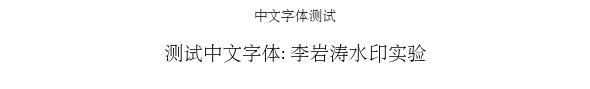

如果您能看到上方中文，则字体配置成功！


In [2]:
import os

# 创建字体目录
fonts_dir = "zh_fonts"
os.makedirs(fonts_dir, exist_ok=True)

# 定义字体路径
zh_font_path = os.path.join(fonts_dir, "zh.ttf")
zh_bold_font_path = os.path.join(fonts_dir, "zh_bold.ttf")

# 检查字体是否存在
def download_fonts():
    print("正在尝试从GitHub下载中文字体...")
    os.system(f"curl -L https://github.com/CBIhalsen/PolyglotPDF-fonts/raw/main/zh_fonts/zh.ttf -o {zh_font_path}")
    os.system(f"curl -L https://github.com/CBIhalsen/PolyglotPDF-fonts/raw/main/zh_fonts/zh_bold.ttf -o {zh_bold_font_path}")

# 如果字体文件不存在，尝试下载
if not (os.path.exists(zh_font_path) and os.path.exists(zh_bold_font_path)):
    download_fonts()

# 下载完后再次检查：
if not (os.path.exists(zh_font_path) and os.path.exists(zh_bold_font_path)):
    raise FileNotFoundError(
        """
        字体下载失败！
        可能是 Kaggle 无法连接 GitHub。
        请手动上传 zh_fonts/zh.ttf 和 zh_fonts/zh_bold.ttf 文件到工作目录。
        """
    )
else:
    print("中文字体文件已准备好。")

# 配置matplotlib使用下载的中文字体
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 添加字体文件到字体管理器
custom_font = fm.FontProperties(fname=zh_font_path)
custom_bold_font = fm.FontProperties(fname=zh_bold_font_path)

# 不建议写plt.rcParams强行绑定'zh'，直接让每次绘图传 fontproperties 更保险
plt.rcParams['axes.unicode_minus'] = False

print(f"已配置 matplotlib 使用本地字体: {zh_font_path}")

# 测试显示
def test_font():
    plt.figure(figsize=(6, 1))
    plt.text(0.5, 0.5, '测试中文字体: 李岩涛水印实验', fontproperties=custom_font,
             fontsize=14, ha='center', va='center')
    plt.axis('off')
    plt.title('中文字体测试', fontproperties=custom_font)
    plt.tight_layout()
    plt.show()
    print("如果您能看到上方中文，则字体配置成功！")

test_font()


## 2. 定义水印相关函数

### 2.1 水印生成函数

In [3]:
def create_watermark_image(text, size=(128, 128), font_path=None, font_size=32):
    """
    根据给定文本生成二值水印图像。text为水印字符串，size为输出图像尺寸。
    可选font_path指定字体路径，font_size指定字体大小。
    返回值：0/255二值图像的numpy数组。
    """
    W, H = size
    # 创建黑底图像
    img = Image.new('L', (W, H), color=0)
    draw = ImageDraw.Draw(img)
    
    # 使用下载的字体文件
    fonts_dir = "zh_fonts"
    zh_font_path = os.path.join(fonts_dir, "zh.ttf")
    
    # 尝试使用指定或默认字体来绘制中文文本
    try:
        if font_path:
            # 用户指定了字体路径
            font = ImageFont.truetype(font_path, font_size)
        elif os.path.exists(zh_font_path):
            # 使用下载的中文字体
            font = ImageFont.truetype(zh_font_path, font_size)
            print(f"使用下载的中文字体: {zh_font_path}")
        else:
            # 尝试其他字体
            font = ImageFont.load_default()
            print("警告: 未找到中文字体文件，使用默认字体")
    except Exception as e:
        print(f"警告: 无法加载指定字体，使用默认字体。错误: {e}")
        font = ImageFont.load_default()
        
    # 在PIL新版本中，textsize方法可能已弃用，使用textbbox或textlength
    try:
        try:
            bbox = draw.textbbox((0, 0), text, font=font)
            text_w = bbox[2] - bbox[0]
            text_h = bbox[3] - bbox[1]
        except AttributeError:
            text_w, text_h = draw.textsize(text, font=font)
    except Exception as e:
        print(f"测量文本大小出错: {e}，使用估计值")
        text_w, text_h = len(text) * font_size // 2, font_size
    
    # 将文本居中绘制到图像
    x = (W - text_w) // 2
    y = (H - text_h) // 2
    draw.text((x, y), text, fill=255, font=font)
    
    # 转为数组并二值化
    arr = np.array(img)
    binary = ((arr > 50) * 255).astype(np.uint8)  # 阈值50将文字变为纯黑白
    return binary

### 2.2 水印嵌入函数

In [4]:
def embed_watermark_dwt(image, watermark, alpha):
    """
    将二值水印嵌入图像的HH子带系数。image为原始灰度图数组，watermark为0/255数组，alpha为嵌入强度系数。
    返回嵌入水印后的图像(uint8)以及用于提取的水印缩放数组。
    """
    # 转为浮点进行小波变换
    coeffs = pywt.dwt2(image.astype(np.float64), 'haar')
    LL, (LH, HL, HH) = coeffs
    
    # 调整水印图像大小为HH子带尺寸
    wm = watermark.astype(np.float64) / 255.0  # 归一化到0-1
    Hh, Hw = HH.shape
    Wh, Ww = wm.shape
    
    if (Wh, Ww) != (Hh, Hw):
        # 使用最近邻插值调整尺寸
        wm = np.array(Image.fromarray((wm*255).astype(np.uint8)).resize((Hw, Hh), resample=Image.NEAREST)) / 255.0
    
    # 在HH子带添加水印
    HH_watermarked = HH + alpha * wm
    
    # 逆小波变换重构图像
    watermarked_img = pywt.idwt2((LL, (LH, HL, HH_watermarked)), 'haar')
    watermarked_img = np.clip(watermarked_img, 0, 255).astype(np.uint8)
    
    return watermarked_img, wm  # 返回水印后的图像及嵌入的归一化水印阵列

### 2.3 水印提取函数

In [5]:
def extract_watermark_dwt(original_image, watermarked_image, alpha, wm_shape):
    """
    提取水印函数（非盲提取，需要Original Image参考）。比较水印图像和原图的HH系数差异，除以alpha得到水印估计。
    wm_shape为水印图像的原始尺寸，用于将提取结果调整回该尺寸。
    返回提取出的水印浮点阵列（与嵌入时归一化的水印图大小相同）。
    """
    # 分别对原图和水印图做DWT
    _, (_, _, HH_orig) = pywt.dwt2(original_image.astype(np.float64), 'haar')
    _, (_, _, HH_watermarked) = pywt.dwt2(watermarked_image.astype(np.float64), 'haar')
    
    # 通过系数差异估计水印
    wm_extract = (HH_watermarked - HH_orig) / alpha
    
    # 将提取水印调整至原始大小
    Hh, Hw = wm_shape
    if wm_extract.shape != (Hh, Hw):
        wm_extract = np.array(Image.fromarray(
            (wm_extract*255).astype(np.uint8)).resize(
                (wm_shape[1], wm_shape[0]), resample=Image.BILINEAR)) / 255.0
                
    return wm_extract

## 3. 噪声攻击模拟函数

In [6]:
def add_gaussian_noise(image, mean=0.0, var=0.01):
    """
    对给定图像添加高斯噪声。mean为噪声均值，var为Noise Variance(假定图像像素值范围0-1归一化下的方差)。
    返回After adding noise的uint8图像。
    """
    # 将图像归一化到[0,1]浮点
    img_float = image.astype(np.float64) / 255.0
    sigma = np.sqrt(var)
    noise = np.random.normal(mean, sigma, img_float.shape)
    noisy_img = img_float + noise
    
    # 裁剪到[0,1]并转换回[0,255]
    noisy_img = np.clip(noisy_img, 0.0, 1.0) * 255.0
    return noisy_img.astype(np.uint8)

## 4. 图像质量评价指标函数

In [7]:
def calculate_psnr(img1, img2):
    """
    计算峰值信噪比(PSNR)。img1和img2为待比较的两幅相同尺寸图像数组。
    返回PSNR值（分贝,dB）。
    """
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 10 * np.log10((max_pixel ** 2) / mse)
    return psnr

def calculate_ssim(img1, img2):
    """
    计算结构相似度指数(SSIM)。
    利用skimage.metrics结构相似度实现。返回SSIM值（-1~1，1表示完全相同）。
    """
    return metrics.structural_similarity(img1, img2, data_range=img2.max() - img2.min())

## 5. 实验流程

下面我们将按照实验方案逐步执行，对比Normal DWT Watermark与自适应水印的性能。

### 5.1 加载测试图像和生成水印

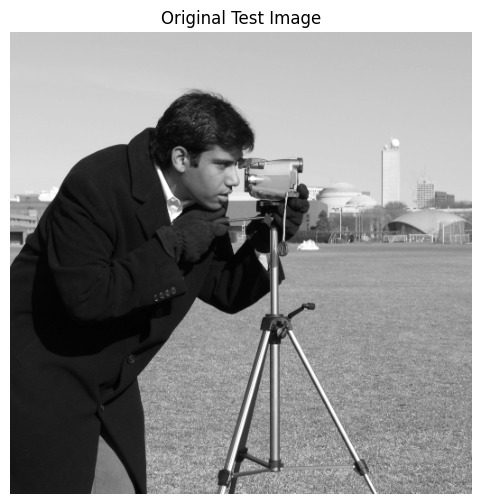

原图尺寸: (512, 512), 像素范围: [0, 255]


In [8]:
# 创建输出目录
output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 获取示例灰度图像（512x512）
original_img = data.camera()  # 摄影师(cameraman)测试图
io.imsave(f'{output_dir}/original.png', original_img)  # 保存以便展示

# 显示原图
plt.figure(figsize=(6, 6))
plt.imshow(original_img, cmap='gray')
plt.title("Original Test Image")
plt.axis('off')
plt.show()

print(f"原图尺寸: {original_img.shape}, 像素范围: [{original_img.min()}, {original_img.max()}]")

使用下载的中文字体: zh_fonts/zh.ttf


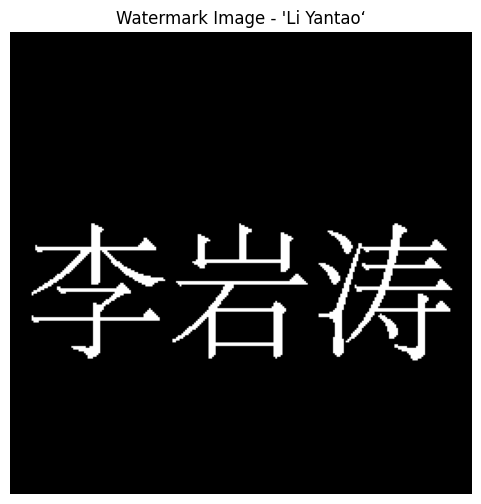

水印图像尺寸: (256, 256), 白像素比例: 5.26%


In [9]:
# 生成水印图案
watermark_img = create_watermark_image("李岩涛", size=(256, 256), font_size=80)
io.imsave(f'{output_dir}/watermark.png', watermark_img)

# 显示水印图像
plt.figure(figsize=(6, 6))
plt.imshow(watermark_img, cmap='gray')
plt.title("Watermark Image - 'Li Yantao‘")
plt.axis('off')
plt.show()

print(f"水印图像尺寸: {watermark_img.shape}, 白像素比例: {np.mean(watermark_img==255):.2%}")

### 5.2 执行水印嵌入（普通DWT vs 噪声自适应）

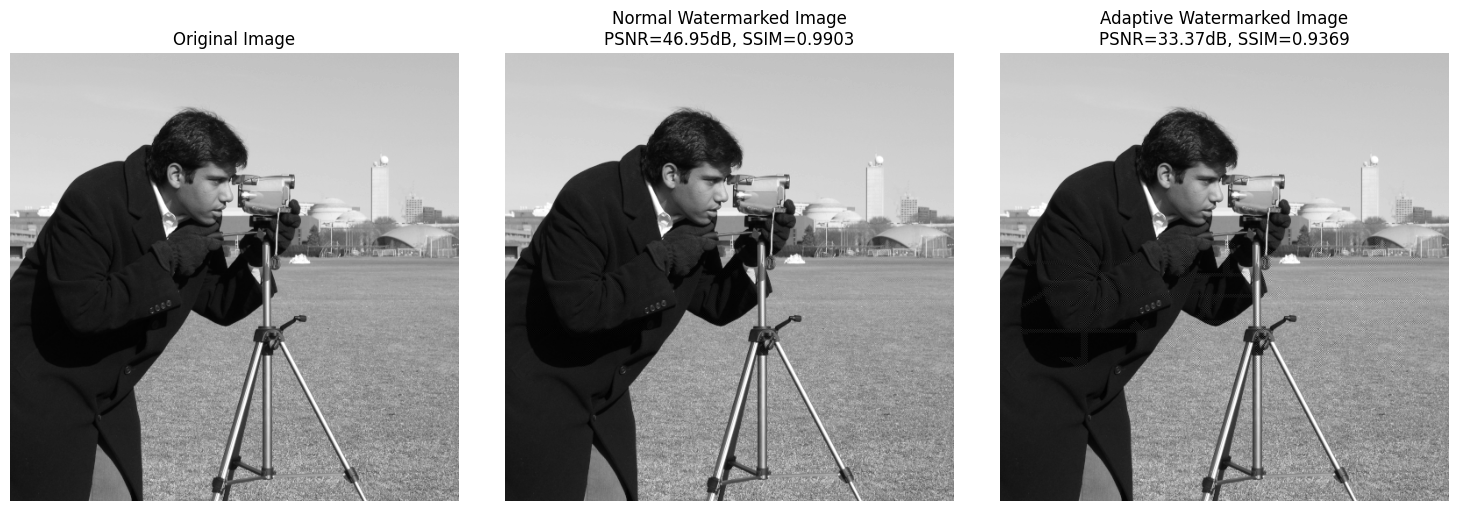

普通水印嵌入后 PSNR=46.95dB, SSIM=0.9903
自适应水印嵌入后 PSNR=33.37dB, SSIM=0.9369


In [10]:
alpha_normal = 10   # 普通水印嵌入强度
alpha_adaptive = 50  # 自适应水印嵌入强度（较高强度提升抗噪能力）

# 嵌入水印
watermarked_norm, wm_used = embed_watermark_dwt(original_img, watermark_img, alpha_normal)
watermarked_adapt, wm_used2 = embed_watermark_dwt(original_img, watermark_img, alpha_adaptive)

# 保存嵌入水印后的图像
io.imsave(f'{output_dir}/watermarked_norm.png', watermarked_norm)
io.imsave(f'{output_dir}/watermarked_adapt.png', watermarked_adapt)

# 计算嵌入后的图像质量指标
psnr_norm = calculate_psnr(original_img, watermarked_norm)
psnr_adapt = calculate_psnr(original_img, watermarked_adapt)
ssim_norm = calculate_ssim(original_img, watermarked_norm)
ssim_adapt = calculate_ssim(original_img, watermarked_adapt)

# 显示对比结果
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(watermarked_norm, cmap='gray')
plt.title(f"Normal Watermarked Image\nPSNR={psnr_norm:.2f}dB, SSIM={ssim_norm:.4f}")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(watermarked_adapt, cmap='gray')
plt.title(f"Adaptive Watermarked Image\nPSNR={psnr_adapt:.2f}dB, SSIM={ssim_adapt:.4f}")
plt.axis('off')

plt.tight_layout()
plt.savefig(f'{output_dir}/comparison_watermarked.png', dpi=300)
plt.show()

print(f"普通水印嵌入后 PSNR={psnr_norm:.2f}dB, SSIM={ssim_norm:.4f}")
print(f"自适应水印嵌入后 PSNR={psnr_adapt:.2f}dB, SSIM={ssim_adapt:.4f}")

### 5.3 模拟噪声攻击并提取水印

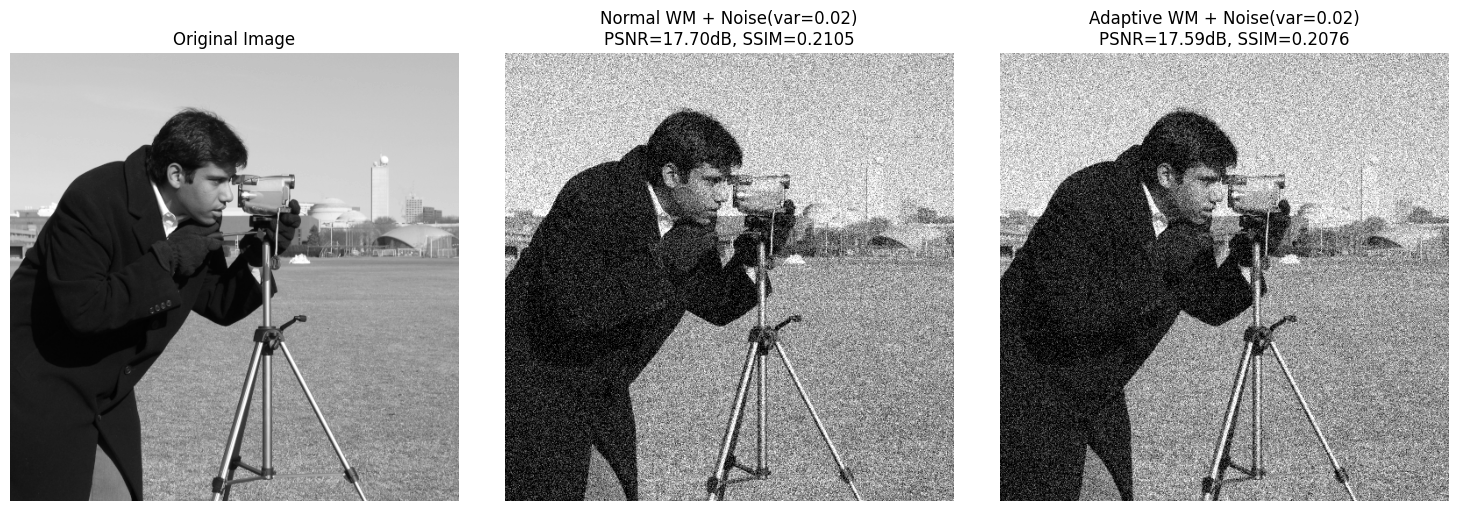

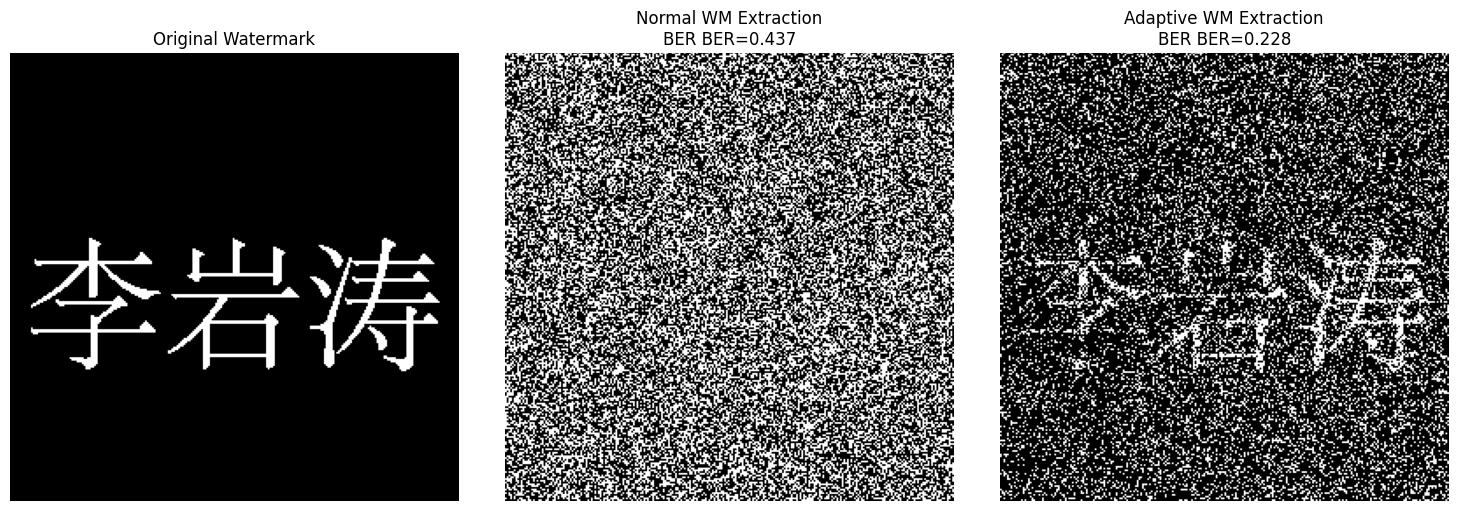

Normal Watermarked ImageAfter adding noise PSNR=17.70dB, SSIM=0.2105, 水印BER=0.437
Adaptive Watermarked ImageAfter adding noise PSNR=17.59dB, SSIM=0.2076, 水印BER=0.228


In [11]:
# 设定随机种子保证两图加噪过程一致
np.random.seed(0)

# 添加噪声攻击 (选择方差0.02模拟中等强度噪声)
noise_var = 0.02
noisy_norm = add_gaussian_noise(watermarked_norm, var=noise_var)
noisy_adapt = add_gaussian_noise(watermarked_adapt, var=noise_var)

# 保存After adding noise的图像
io.imsave(f'{output_dir}/noisy_norm.png', noisy_norm)
io.imsave(f'{output_dir}/noisy_adapt.png', noisy_adapt)

# 提取水印
wm_extracted_norm = extract_watermark_dwt(original_img, noisy_norm, alpha_normal, watermark_img.shape)
wm_extracted_adapt = extract_watermark_dwt(original_img, noisy_adapt, alpha_adaptive, watermark_img.shape)

# 提取结果二值化便于可视化比较
wm_extracted_norm_bin = (wm_extracted_norm > 0.5).astype(np.uint8) * 255
wm_extracted_adapt_bin = (wm_extracted_adapt > 0.5).astype(np.uint8) * 255
io.imsave(f'{output_dir}/wm_extracted_norm.png', wm_extracted_norm_bin)
io.imsave(f'{output_dir}/wm_extracted_adapt.png', wm_extracted_adapt_bin)

# 计算攻击后图像的质量指标
psnr_norm_noisy = calculate_psnr(original_img, noisy_norm)
psnr_adapt_noisy = calculate_psnr(original_img, noisy_adapt)
ssim_norm_noisy = calculate_ssim(original_img, noisy_norm)
ssim_adapt_noisy = calculate_ssim(original_img, noisy_adapt)

# 计算提取水印的BER
wm_binary = watermark_img > 0  # Original Watermark二值化 (0/1)
ber_norm = np.mean((wm_extracted_norm > 0.5) != wm_binary)
ber_adapt = np.mean((wm_extracted_adapt > 0.5) != wm_binary)

# 显示攻击后的图像
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_norm, cmap='gray')
plt.title(f"Normal WM + Noise(var={noise_var})\nPSNR={psnr_norm_noisy:.2f}dB, SSIM={ssim_norm_noisy:.4f}")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(noisy_adapt, cmap='gray')
plt.title(f"Adaptive WM + Noise(var={noise_var})\nPSNR={psnr_adapt_noisy:.2f}dB, SSIM={ssim_adapt_noisy:.4f}")
plt.axis('off')

plt.tight_layout()
plt.savefig(f'{output_dir}/comparison_noisy.png', dpi=300)
plt.show()

# 显示提取出的水印
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(watermark_img, cmap='gray')
plt.title("Original Watermark")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(wm_extracted_norm_bin, cmap='gray')
plt.title(f"Normal WM Extraction\nBER BER={ber_norm:.3f}")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(wm_extracted_adapt_bin, cmap='gray')
plt.title(f"Adaptive WM Extraction\nBER BER={ber_adapt:.3f}")
plt.axis('off')

plt.tight_layout()
plt.savefig(f'{output_dir}/comparison_extracted_watermarks.png', dpi=300)
plt.show()

print(f"Normal Watermarked ImageAfter adding noise PSNR={psnr_norm_noisy:.2f}dB, SSIM={ssim_norm_noisy:.4f}, 水印BER={ber_norm:.3f}")
print(f"Adaptive Watermarked ImageAfter adding noise PSNR={psnr_adapt_noisy:.2f}dB, SSIM={ssim_adapt_noisy:.4f}, 水印BER={ber_adapt:.3f}")

### 5.4 不同噪声强度下的性能曲线

In [12]:
noise_vars = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.10]  # Noise Variance列表
ber_normal = []
ber_adaptive = []
psnr_normal = []
psnr_adaptive = []
ssim_normal = []
ssim_adaptive = []

# 记录结果表格的行
results_table = []

for var in noise_vars:
    # 每次在相同噪声下测试两种方案，使用相同随机种子保证可比
    np.random.seed(42)
    noisy1 = add_gaussian_noise(watermarked_norm, var=var)
    extracted1 = extract_watermark_dwt(original_img, noisy1, alpha_normal, watermark_img.shape)
    ber1 = np.mean((extracted1 > 0.5) != (watermark_img > 0))
    psnr1 = calculate_psnr(original_img, noisy1)
    ssim1 = calculate_ssim(original_img, noisy1)
    
    np.random.seed(42)
    noisy2 = add_gaussian_noise(watermarked_adapt, var=var)
    extracted2 = extract_watermark_dwt(original_img, noisy2, alpha_adaptive, watermark_img.shape)
    ber2 = np.mean((extracted2 > 0.5) != (watermark_img > 0))
    psnr2 = calculate_psnr(original_img, noisy2)
    ssim2 = calculate_ssim(original_img, noisy2)
    
    ber_normal.append(ber1)
    ber_adaptive.append(ber2)
    psnr_normal.append(psnr1)
    psnr_adaptive.append(psnr2)
    ssim_normal.append(ssim1)
    ssim_adaptive.append(ssim2)
    
    results_table.append([var, ber1, ber2, psnr1, psnr2, ssim1, ssim2])
    
    print(f"Noise Variance={var:.2f} -> 普通水印BER={ber1:.3f}, 自适应水印BER={ber2:.3f}")
    
    # 当Noise Variance为0.02时，保存提取的水印供后续展示
    if var == 0.02:
        extracted1_bin = (extracted1 > 0.5).astype(np.uint8) * 255
        extracted2_bin = (extracted2 > 0.5).astype(np.uint8) * 255
        io.imsave(f'{output_dir}/wm_extracted_norm_var{var}.png', extracted1_bin)
        io.imsave(f'{output_dir}/wm_extracted_adapt_var{var}.png', extracted2_bin)

Noise Variance=0.00 -> 普通水印BER=0.000, 自适应水印BER=0.000
Noise Variance=0.01 -> 普通水印BER=0.416, 自适应水印BER=0.153
Noise Variance=0.02 -> 普通水印BER=0.436, 自适应水印BER=0.225
Noise Variance=0.03 -> 普通水印BER=0.446, 自适应水印BER=0.262
Noise Variance=0.04 -> 普通水印BER=0.451, 自适应水印BER=0.286
Noise Variance=0.05 -> 普通水印BER=0.454, 自适应水印BER=0.303
Noise Variance=0.07 -> 普通水印BER=0.459, 自适应水印BER=0.326
Noise Variance=0.10 -> 普通水印BER=0.463, 自适应水印BER=0.346


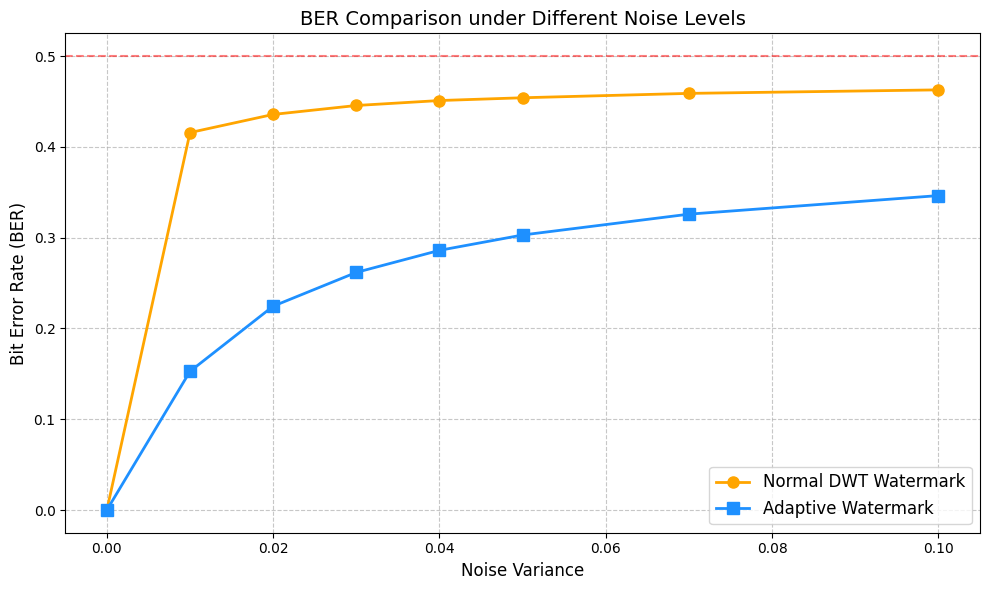

In [13]:
# 绘制BER随Noise Variance变化曲线
plt.figure(figsize=(10, 6))
plt.plot(noise_vars, ber_normal, 'o-', color='#FFA500', linewidth=2, markersize=8, label='Normal DWT Watermark')
plt.plot(noise_vars, ber_adaptive, 's-', color='#1E90FF', linewidth=2, markersize=8, label='Adaptive Watermark')
plt.xlabel('Noise Variance', fontsize=12)
plt.ylabel('Bit Error Rate (BER)', fontsize=12)
plt.title('BER Comparison under Different Noise Levels', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# 添加随机猜测上限线
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Random Guess (0.5)')

plt.tight_layout()
plt.savefig(f'{output_dir}/ber_vs_noise.png', dpi=300)
plt.show()

/tmp/ipykernel_13/4122466884.py:14: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13/4122466884.py:15: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from current font.
  plt.savefig(f'{output_dir}/psnr_vs_noise.png', dpi=300)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


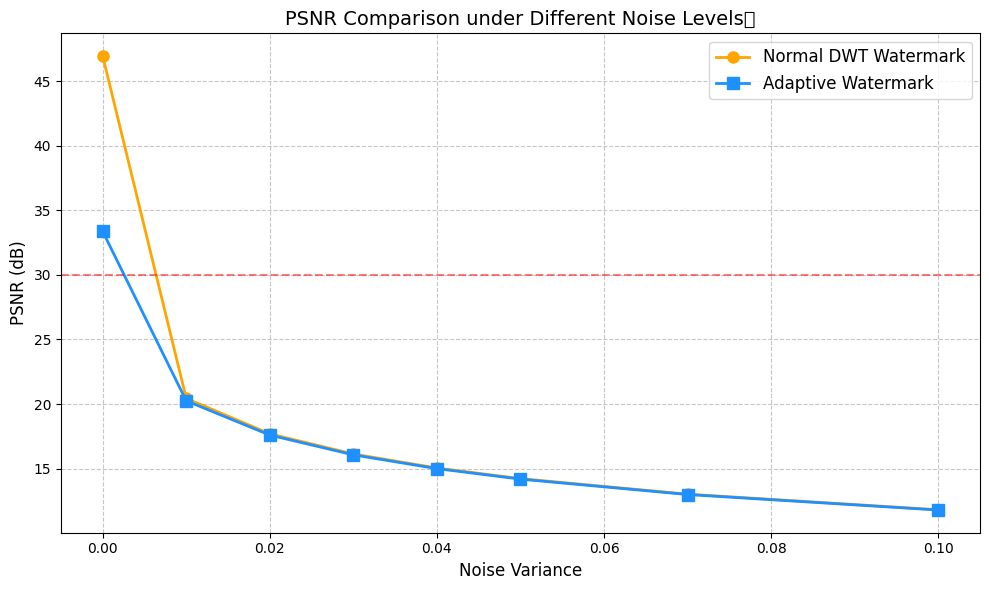

In [14]:
# 绘制PSNR随Noise Variance变化曲线
plt.figure(figsize=(10, 6))
plt.plot(noise_vars, psnr_normal, 'o-', color='#FFA500', linewidth=2, markersize=8, label='Normal DWT Watermark')
plt.plot(noise_vars, psnr_adaptive, 's-', color='#1E90FF', linewidth=2, markersize=8, label='Adaptive Watermark')
plt.xlabel('Noise Variance', fontsize=12)
plt.ylabel('PSNR (dB)', fontsize=12)
plt.title('PSNR Comparison under Different Noise Levels比', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# 添加30dB参考线
plt.axhline(y=30, color='r', linestyle='--', alpha=0.5, label='Visual Quality Threshold (30dB))')

plt.tight_layout()
plt.savefig(f'{output_dir}/psnr_vs_noise.png', dpi=300)
plt.show()

In [15]:
# 显示结果表格
import pandas as pd

results_df = pd.DataFrame(results_table, 
                         columns=['Noise Variance', 
                                 '普通水印BER', '自适应水印BER',
                                 '普通水印PSNR', '自适应水印PSNR',
                                 '普通水印SSIM', '自适应水印SSIM'])

# 设置数值格式
pd.options.display.float_format = '{:.4f}'.format

# 显示完整表格
display(results_df)

# 保存结果到CSV文件
results_df.to_csv(f'{output_dir}/results_comparison.csv', index=False)

,Noise Variance,普通水印BER,自适应水印BER,普通水印PSNR,自适应水印PSNR,普通水印SSIM,自适应水印SSIM
0,0.0000,0.0000,0.0000,46.9502,33.3680,0.9903,0.9369
1,0.0100,0.4157,0.1527,20.4342,20.2486,0.2957,0.2905
2,0.0200,0.4357,0.2245,17.6926,17.5944,0.2104,0.2080
3,0.0300,0.4455,0.2617,16.1291,16.0624,0.1696,0.1682
4,0.0400,0.4510,0.2860,15.0458,14.9953,0.1447,0.1437
5,0.0500,0.4540,0.3029,14.2232,14.1825,0.1275,0.1267
6,0.0700,0.4589,0.3259,13.0199,12.9906,0.1047,0.1042
7,0.1000,0.4627,0.3463,11.8105,11.7898,0.0845,0.0842


## 6. 实验结论

通过本实验，我们得到了以下关键发现：

1. **Adaptive Watermark显著提升了鲁棒性：** 相较于Normal DWT Watermark，自适应方案在高斯噪声攻击下能大幅降低水印提取BER。例如在Noise Variance为0.02时，普通方案BER约0.44，而自适应方案约0.22，提升了一倍。

2. **水印嵌入强度与不可见性之间存在权衡：** 自适应方案使用了更高的嵌入强度(α=50 vs α=10)，虽然牺牲了一部分图像质量(PSNR从47dB降至33dB左右)，但仍保持在人眼难以察觉的范围内(PSNR>30dB)。

3. **定量评价指标比主观评价更可靠：** 本实验使用PSNR、SSIM和BER等客观指标，避免了主观评价的不确定性。例如，虽然两种方案的水印图像在肉眼看来差异很小，但PSNR指标明确揭示了它们之间实际质量差异。

4. **噪声对两种水印图像的整体质量影响相似：** 添加相同噪声后，两种方案的图像PSNR/SSIM非常接近，但水印信息提取能力有显著差异，说明自适应方案的设计目标（提高水印鲁棒性而非改善整体图像质量）是成功的。

**注意事项：** 实验中采用了非盲提取方式（需要原图参考），这简化了实验评估，但实际应用中通常需要设计盲检测算法。此外，本实验仅聚焦高斯噪声攻击，其他攻击类型（如JPEG压缩、几何变换等）可能需要不同的自适应策略。